# Spark imageprocessing

Proces a directory with images

## Import libraries

In [1]:
from typing import Iterator

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType

from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50

import tensorflow as tf
import numpy as np
import pandas as pd
import random

## Start a spark session

In [2]:
spark = SparkSession.builder.appName("LocalResNet").master("local[2]").getOrCreate()

21/12/03 21:01:41 WARN Utils: Your hostname, KgMBP2020.local resolves to a loopback address: 127.0.0.1; using 192.168.178.71 instead (on interface en0)
21/12/03 21:01:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/03 21:01:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/03 21:01:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read images into a Spark DataFrame

In [3]:
images_dir = "../data/images/vanalleswat/"
image_df = spark.read.format("image").load(images_dir).filter("image.height > 0")

In [4]:
image_df.select("image.origin", "image.height", "image.width", "image.mode", "image.nChannels").show(5)

+--------------------+------+-----+----+---------+
|              origin|height|width|mode|nChannels|
+--------------------+------+-----+----+---------+
|file:///Users/kge...|   318|  500|  16|        3|
|file:///Users/kge...|   333|  500|  16|        3|
|file:///Users/kge...|   332|  500|  16|        3|
|file:///Users/kge...|   333|  500|  16|        3|
|file:///Users/kge...|   319|  500|  16|        3|
+--------------------+------+-----+----+---------+
only showing top 5 rows



### Select a single image to show the image preprocessing steps

In [5]:
random_row = random.randint(0,image_df.count())
random_row

23

In [6]:
spark_single_img = image_df.select("image").collect()[random_row]
(spark_single_img.image.origin, spark_single_img.image.mode, spark_single_img.image.nChannels )

('file:///Users/kgeusebroek/dev/godatadriven/projects/gdd-friday/spark-tensorflow/data/images/vanalleswat/valhuman02-23.png',
 24,
 4)

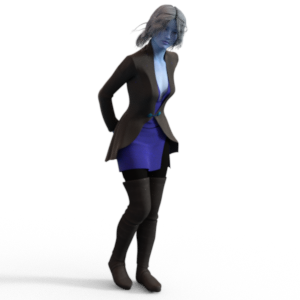

In [7]:
mode = 'RGBA' if (spark_single_img.image.nChannels == 4) else 'RGB' 
Image.frombytes(mode=mode, data=bytes(spark_single_img.image.data), size=[spark_single_img.image.width,spark_single_img.image.height])

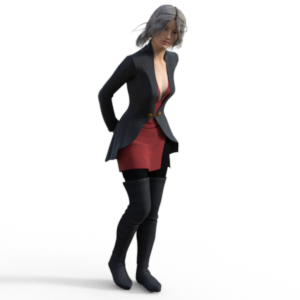

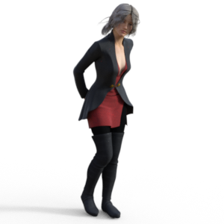

In [8]:
arr = np.frombuffer(spark_single_img.image.data, dtype=np.uint8)
arr_reshaped = arr.reshape([spark_single_img.image.height,spark_single_img.image.width, spark_single_img.image.nChannels])

if (spark_single_img.image.nChannels == 4):
    B, G, R, A = arr_reshaped.T
    rgb_image_array = np.array((R, G, B, A)).T
else:
    B, G, R = arr_reshaped.T
    rgb_image_array = np.array((R, G, B)).T

img = Image.fromarray(rgb_image_array)
img_resized = img.resize([224, 224])
arr_resized = np.asarray(img_resized)
img_resized = Image.fromarray(arr_resized)

display(img, img_resized)

## Transform image into resized image with Spark

In [9]:
schema = StructType(image_df.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T
    
def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=img_data.data, size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([224, 224], resample=Image.BICUBIC) if (resize) else img
    arr = convert_bgr_array_to_rgb_array(np.asarray(img))
    arr = arr.reshape([224*224*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch

resized_df = image_df.select("image.*").mapInPandas(resize_image_udf, schema)


In [10]:
row = resized_df.collect()[random_row]

In [11]:
# for row in resized_df.collect():
#     Image.frombytes(mode='RGB', data=bytes(row.array), size=[224,224]).show()

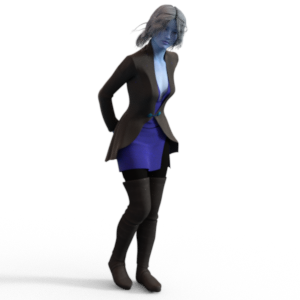

In [12]:
mode = 'RGBA' if (row.nChannels == 4) else 'RGB' 
Image.frombytes(mode=mode, data=bytes(row.data), size=[row.width,row.height])

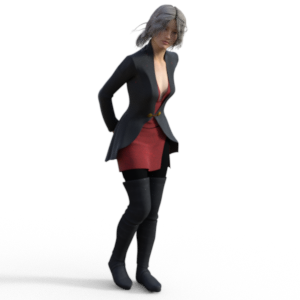

In [13]:
Image.frombytes(mode='RGB', data=bytes(row.data_as_array), size=[row.width,row.height])

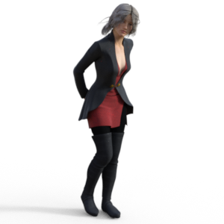

In [14]:
Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224])

## Prediction

In [15]:
def normalize_array(arr):
    return tf.keras.applications.resnet50.preprocess_input(arr.reshape([224,224,3]))

@pandas_udf(ArrayType(FloatType()))
def predict_batch_udf(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = ResNet50()
    for input_array in iterator:
        normalized_input = np.stack(input_array.map(normalize_array))
        preds = model.predict(normalized_input)
        yield pd.Series(list(preds))

In [16]:
predicted_df = resized_df.withColumn("predictions", predict_batch_udf("data_as_resized_array"))

In [17]:
prediction_row = predicted_df.collect()[random_row]

2021-12-03 21:02:00.260095: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 21:02:00.574991: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
prediction_row.predictions

tf.keras.applications.resnet50.decode_predictions(
    np.array(prediction_row.predictions).reshape(1,1000), top=5
)

[[('n03710637', 'maillot', 0.2882238030433655),
  ('n03255030', 'dumbbell', 0.07994653284549713),
  ('n03976657', 'pole', 0.0757366269826889),
  ('n03710721', 'maillot', 0.06385179609060287),
  ('n04023962', 'punching_bag', 0.04312119632959366)]]

In [19]:
decoded_predictions_schema = StructType(predicted_df.schema.fields + [
    StructField("pred_id", ArrayType(StringType()), False),
    StructField("label", ArrayType(StringType()), False),
    StructField("score", ArrayType(FloatType()), False)
])

def top5_predictions(preds):
    return tf.keras.applications.resnet50.decode_predictions(
        np.array(preds).reshape(1,1000), top=5
    )

# @pandas_udf(decoded_predictions_schema)
def top5predictions_batch_udf(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in iterator:
        # pd.merge(pdf, right=pd.concat([pd.DataFrame(bar, columns=["pred_id", "label", "score"]).aggregate(lambda x: [x.tolist()], axis=0) for [bar] in foo]).reset_index(drop=True), left_index=True, right_index=True)
        yield pd.merge(
            dataframe_batch, 
            right=pd.concat([pd.DataFrame(top5, columns=["pred_id", "label", "score"]).aggregate(lambda x: [x.tolist()], axis=0) for [top5] in dataframe_batch.predictions.map(top5_predictions)]).reset_index(drop=True),
            left_index=True,
            right_index=True
        )
        
        # pd.DataFrame(dataframe_batch.predictions.map(top5_predictions), columns=["pred_id", "label", "score"]))

In [21]:
top5_predictions_df = predicted_df.mapInPandas(top5predictions_batch_udf, decoded_predictions_schema)


In [23]:
top5_prediction = top5_predictions_df.collect()[random_row]

2021-12-03 21:03:51.312005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 21:03:51.312039: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


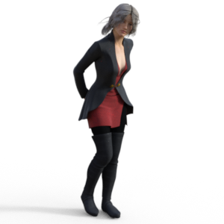

'maillot'

In [31]:
display(Image.frombytes(mode='RGB', data=bytes(top5_prediction.data_as_resized_array), size=[224,224]))
display(top5_prediction.label[0])

2021-12-03 21:06:41.855053: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 21:06:42.096772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


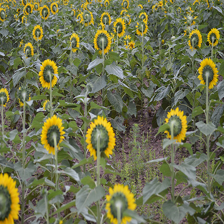

'daisy'

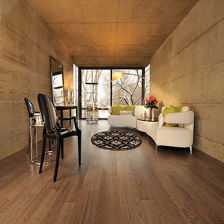

'dining_table'

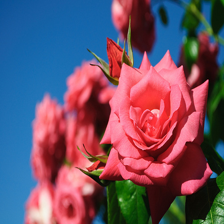

'picket_fence'

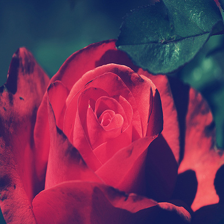

"jack-o'-lantern"

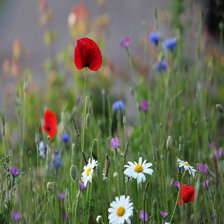

'daisy'

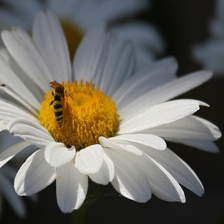

'daisy'

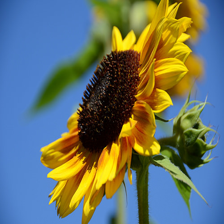

'daisy'

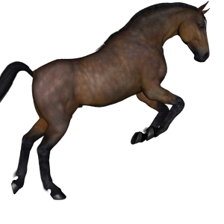

'Mexican_hairless'

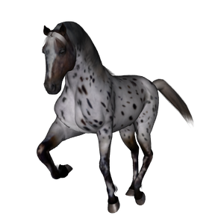

'dalmatian'

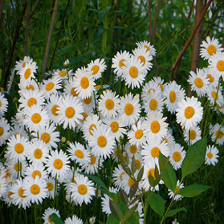

'daisy'

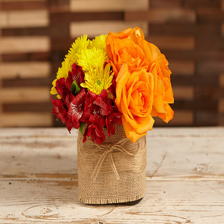

'vase'

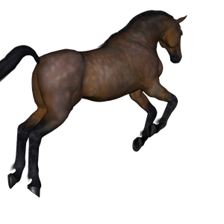

'Mexican_hairless'

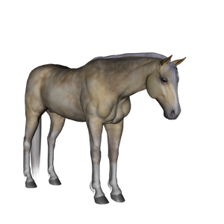

'hartebeest'

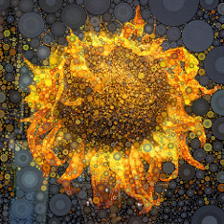

'jellyfish'

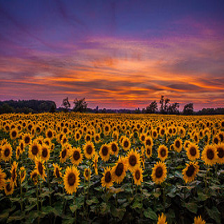

'theater_curtain'

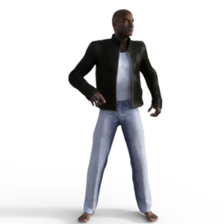

'jean'

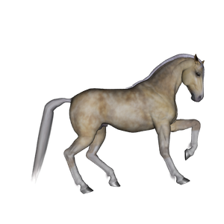

'Great_Dane'

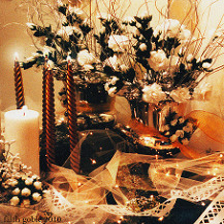

'throne'

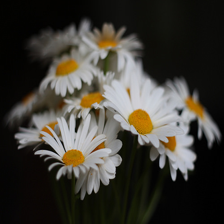

'daisy'

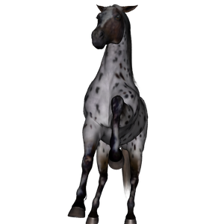

'dalmatian'

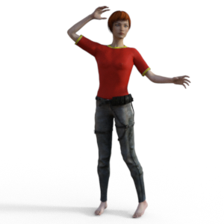

'dumbbell'

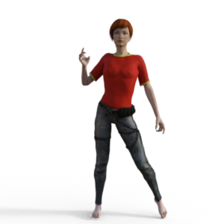

'dumbbell'

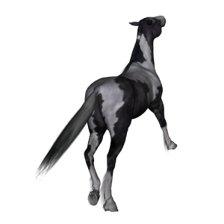

'Weimaraner'

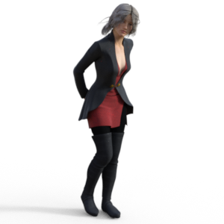

'maillot'

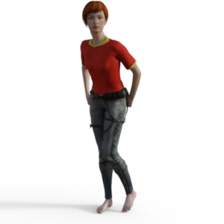

'jean'

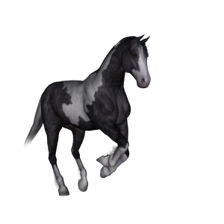

'Weimaraner'

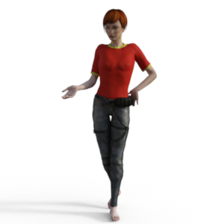

'balance_beam'

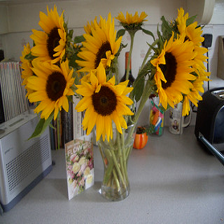

'vase'

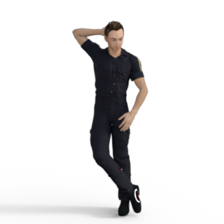

'web_site'

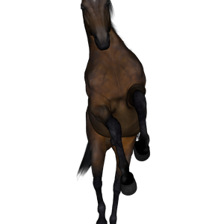

'hartebeest'

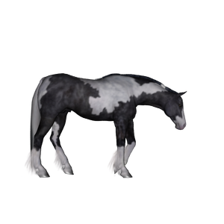

'Boston_bull'

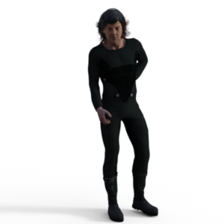

'dumbbell'

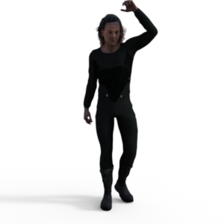

'dumbbell'

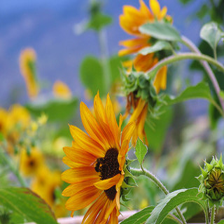

'bee'

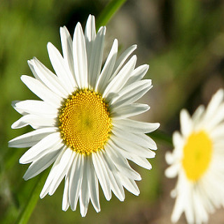

'daisy'

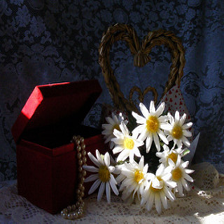

'altar'

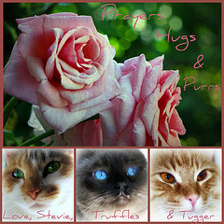

'web_site'

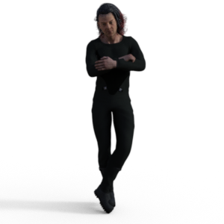

'dumbbell'

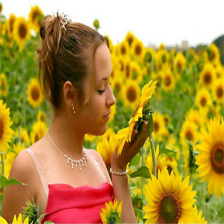

'rapeseed'

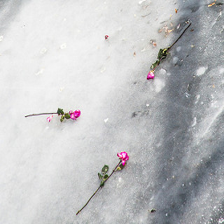

'safety_pin'

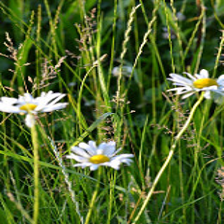

'daisy'

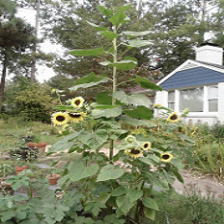

'giant_panda'

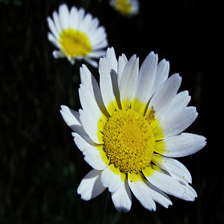

'daisy'

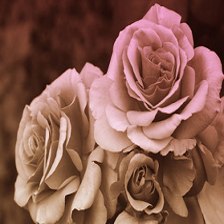

'vase'

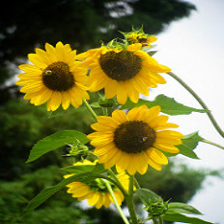

'daisy'

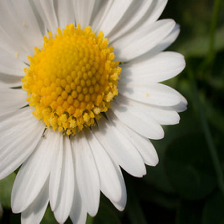

'daisy'

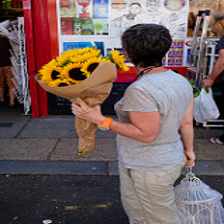

'toyshop'

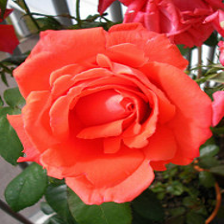

'greenhouse'

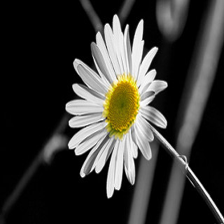

'daisy'

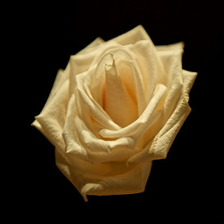

'conch'

In [33]:
for row in top5_predictions_df.collect():
    display(Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]))
    display(row.label[0])